In [2]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [3]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Predicted: [('n07768694', 'pomegranate', 0.5918393), ('n07742313', 'Granny_Smith', 0.2637073), ('n07753113', 'fig', 0.052438933)]


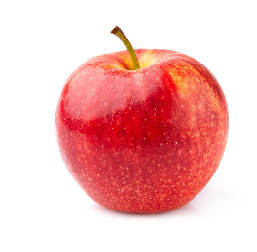

In [4]:
img_path = 'apple.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

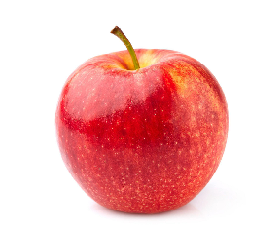

In [5]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
plot_img(x)

In [6]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
#x_noise = np.zeros_like(x)

In [7]:
#x_adv

In [17]:
# Set variables
epochs = 400
epsilon = 0.01
target_class = 943 # cucumber
prev_probs = []
prev_original_class=[]

noise_images_data=[]
processed_images_data=[]
top_one_category=[]
top_one_confidence=[]
top_two_category=[]
top_two_confidence=[]

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1*K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    #x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])
    prev_original_class.append(preds[0][948])

    if i%10==0:
        print(i, preds[0][target_class], vgg16.decode_predictions(preds, top=2)[0][0][1:3])
        print("\n ")
        #print("epsilon*delta")
        noise_images_data.append(x_adv-x)
        processed_images_data.append(x_adv)
        top_one_category.append(vgg16.decode_predictions(preds, top=2)[0][0][1])
        top_one_confidence.append(vgg16.decode_predictions(preds, top=2)[0][0][2])
        top_two_category.append(vgg16.decode_predictions(preds, top=2)[0][1][1])
        top_two_confidence.append(vgg16.decode_predictions(preds, top=2)[0][1][2])
        #plot_img(x_adv)
        #plot_img(x_adv-x)

0 0.0029337278 ('Granny_Smith', 0.46328586)

 
10 0.0032173423 ('Granny_Smith', 0.43880782)

 
20 0.0034597334 ('Granny_Smith', 0.40952626)

 
30 0.0036787295 ('Granny_Smith', 0.3761871)

 
40 0.0038102986 ('Granny_Smith', 0.34450063)

 
50 0.003927835 ('Granny_Smith', 0.3121465)

 
60 0.0040376503 ('Granny_Smith', 0.28180936)

 
70 0.0040268954 ('Granny_Smith', 0.253034)

 
80 0.0040097325 ('Granny_Smith', 0.22725958)

 
90 0.003982555 ('candle', 0.21252605)

 
100 0.0039555556 ('candle', 0.2311094)

 
110 0.0038808521 ('candle', 0.2522357)

 
120 0.0037804935 ('candle', 0.27168748)

 
130 0.003623281 ('candle', 0.291719)

 
140 0.0034520428 ('candle', 0.3131324)

 
150 0.0032557235 ('candle', 0.33372357)

 
160 0.0030575471 ('candle', 0.35332066)

 
170 0.0028476878 ('candle', 0.37556535)

 
180 0.0026332547 ('candle', 0.39932975)

 
190 0.0024248194 ('candle', 0.42285612)

 
200 0.0022155084 ('candle', 0.4467836)

 
210 0.002009837 ('candle', 0.47040448)

 
220 0.001818084 ('candle'

In [22]:
from skimage.transform import rescale, resize, downscale_local_mean
def normalized_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    t_final=np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255
#     plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
#     plt.grid('off')
#     plt.axis('off')
#     plt.show()
    t_resized = resize(t_final,(224,224))
    return t_resized

In [ ]:

for number in range(len(top_one_acc)):
    

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


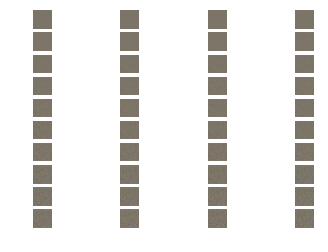

In [23]:
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec




cols = 4
rows = int(math.ceil(len(noise_images_data) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()
for n in range(len(noise_images_data)):
    ax = fig.add_subplot(gs[n])
    resized = normalized_img(noise_images_data[n])
    plt.axis('off')
    plt.imshow(resized,interpolation='none')
    

fig.tight_layout()
plt.savefig('FinalPlot.png',format='png',dpi=1000,bbox_inches='tight')

In [20]:
len(noise_images_data)

40

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

#@tf.function
def conv_fn(image):
  return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# warm up
conv_layer(image); conv_fn(image)
print("Eager conv:", timeit.timeit(lambda: conv_layer(image), number=10))
print("Function conv:", timeit.timeit(lambda: conv_fn(image), number=10))
print("Note how there's not much difference in performance for convolutions")

Eager conv: 0.033820537966676056
Function conv: 0.03556352690793574
Note how there's not much difference in performance for convolutions


In [14]:
import tensorflow.contrib.eager as tfe

In [23]:
x_adv

<tf.Tensor 'add_69:0' shape=(?, 224, 224, 3) dtype=float32>